# Analyze IGF2BP2 RIP in circles
- iteration 6: only 1 replicate
- iteration 10: 3 replicates

# Basic Statistics

In [1]:
import os
import pybedtools
pybedtools.set_bedtools_path('/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/bin/')
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from matplotlib_venn import venn2


indir = Path('/tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/3_pulldown_RIP/output/')

In [2]:
mega_anno = pd.read_csv(indir / 'circle_summary/all_circle_annotation.csv', index_col = 0)
stats_df = pd.read_csv(indir / 'circle_summary/ciri_stats.csv', index_col = 0)
counts = pd.read_csv(indir / 'circle_summary/circ_type_counts.csv', index_col = 0)
bsj = pd.read_csv(indir / 'circle_summary/BSJ_counts.csv', index_col = 0)
fsj = pd.read_csv(indir / 'circle_summary/FSJ_counts.csv', index_col = 0)
junc = pd.read_csv(indir / 'circle_summary/junction_ratio.csv', index_col = 0)

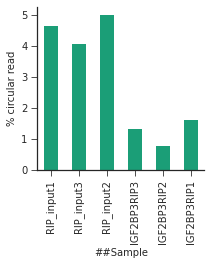

In [3]:
(stats_df['frac_circular']*100).plot.bar(figsize = (3,3))
plt.ylabel('% circular read')
sns.despine()

In [4]:
bsj_cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6
fsj_cpm=fsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

# Types of circular RNA detected

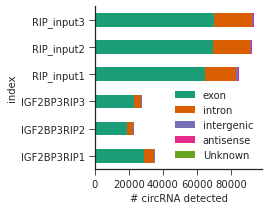

In [5]:
counts.sort_index().plot.barh(stacked = True, figsize = (3,3))
plt.xlabel('# circRNA detected')
sns.despine()

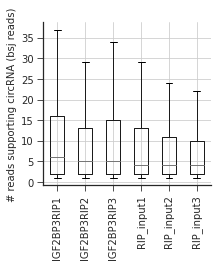

In [6]:
bsj.reindex(sorted(bsj.columns), axis=1).boxplot(showfliers=False, rot = 90,figsize = (3,3))
plt.ylabel('# reads supporting circRNA (bsj reads)')
sns.despine()

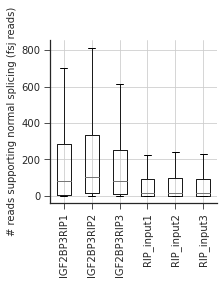

In [7]:
fsj.reindex(sorted(fsj.columns), axis=1).boxplot(showfliers=False, rot = 90,figsize = (3,3))
plt.ylabel('# reads supporting normal splicing (fsj reads)')
sns.despine()

Text(0, 0.5, '(BSJ+1)/(FSJ+1)')

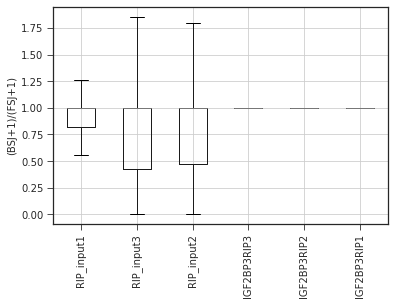

In [8]:
((bsj.fillna(0)+1)/(fsj.fillna(0)+1)).boxplot(showfliers=False, rot = 90)
plt.ylabel('(BSJ+1)/(FSJ+1)')

Text(0.5, 0.98, 'Batch 2(2023-09)')

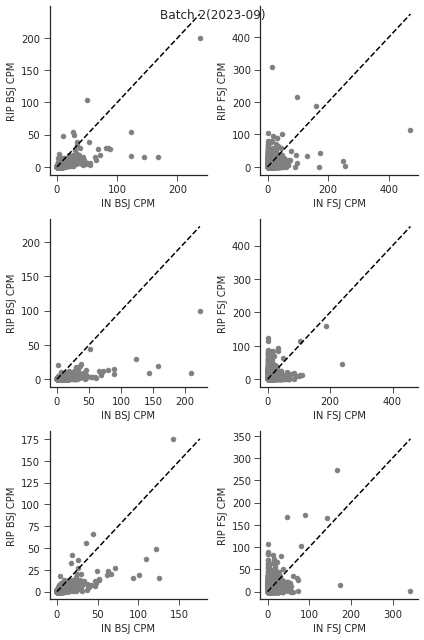

In [9]:
f, axes = plt.subplots(3,2, figsize = (6,9))
for i, rep in enumerate([1,2,3]):
    for j, (arr, rtype)  in enumerate(zip([bsj_cpm, fsj_cpm], ['BSJ','FSJ'])):
        ax = axes[i,j]
        x = f'RIP_input{rep}'
        y = f'IGF2BP3RIP{rep}'
        arr.plot.scatter(x = x, y = y, ax = ax, color = 'grey')
        ax.set_xlabel(f'IN {rtype} CPM')
        ax.set_ylabel(f'RIP {rtype} CPM')
        ax.plot([0,max(arr[x].max(),arr[y].max())],
                  [0,max(arr[x].max(),arr[y].max())],
                   '--', color = 'black'
                  )
plt.tight_layout()
sns.despine()
plt.suptitle('Batch 2(2023-09)')

# CircRIP output

In [10]:
# def read_circRIP_outputs(indir, sample1, sample2):
#     rip_output = pd.read_csv(Path(indir)/'circRIP/'/f'{sample1}_vs_{sample2}',
#     sep = '\t', names = ['circ_id', 'gene', 'BSJs in IP',
#             'circRNA in Input','CPM in IP','CPM in Input',
#             'IP/Input ratio','p-value', 'status'],
#                 comment = '>'
#             )
#     # annotation
#     circ_df, stat = read_ciri_gtf(Path(indir)/f'{sample1}.gtf')
#     rip_output = rip_output.merge(circ_df, left_on = 'circ_id', right_on = 'circ_id')
#     return rip_output

In [11]:
# rip_output = read_circRIP_outputs(indir1, 'IGF2BP3_RIP', 'RIP_input')
# rip_output2_1 = read_circRIP_outputs(indir2, 'IGF2BP3RIP1', 'RIP_input1')
# rip_output2_2 = read_circRIP_outputs(indir2, 'IGF2BP3RIP2', 'RIP_input2')
# rip_output2_3 = read_circRIP_outputs(indir2, 'IGF2BP3RIP3', 'RIP_input3')

In [12]:
# all_rip_outputs = [rip_output, rip_output2_1, rip_output2_2, rip_output2_3]

In [13]:
# f, ax = plt.subplots(2,2, sharex = True, sharey = True)

# rip_output['p-value'].hist(ax = ax[0,0], density = True)
# rip_output2_1['p-value'].hist(ax = ax[1,0], density = True)
# rip_output2_2['p-value'].hist(ax = ax[0,1], density = True)
# rip_output2_3['p-value'].hist(ax = ax[1,1], density = True)
# plt.xlabel('pvalue')
# plt.ylabel('#circRNA')
# sns.despine()

In [14]:
# cnt = rip_output.groupby(by = ['circ_type', 'status']).count()['circ_id'].unstack()
# cnt.T.plot.bar(stacked = True)
# plt.ylabel('# circular RNA')

In [15]:
# rip_output.loc[rip_output['status']=='enriched', 'circ_type'].value_counts().plot.pie()

## compare to published results

In [16]:
# their circular RNA coordinate is start +1
def transform_circular_rna_id(id_):
    chrom, startend = id_.split(':')
    start, end = startend.split('|')
    start = int(start)+1
    return chrom + ':' + str(start)+'|'+end

published = pd.read_excel('../notebook/table_s1_bbac186.xls', skiprows = 1)
published['circ_id']=published['CircRNA ID'].apply(transform_circular_rna_id)

In [17]:
# for output in all_rip_outputs:
#     output['is_published']=output['circ_id'].isin(published['circ_id'])
#     pivot_table = output.groupby(by = ['is_published', 'status']).count()['circ_id'].unstack()
#     odds_ratio = (pivot_table.loc[True, 'enriched']/pivot_table.loc[True, 'non-enriched']
#                  )/(pivot_table.loc[False, 'enriched']/pivot_table.loc[False, 'non-enriched'])
    
#     print(odds_ratio)
    
#     venn2([set(output.loc[output['is_published'], 'circ_id']),
#            set(output.loc[output['status']=='enriched', 'circ_id'])
#           ],set_labels = ['published_IGF2BP3(WM278)', 'Our protocol'])
#     plt.show()

# My outputs

In [18]:
from matplotlib_venn import venn3

In [19]:
!ls /tscc/lustre/ddn/scratch/s5xu/circSTAMP_pipe/3_pulldown_RIP/output/RIP

coef.tsv		    IGF2BP3RIP2.RIP_input2.csv
IGF2BP3RIP1.RIP_input1.csv  IGF2BP3RIP3.RIP_input3.csv


In [20]:
# mega_anno = pd.read_csv(Path(indir2)/'count_table.tsv', sep = '\t', index_col = 0)
my_rip_1 = pd.read_csv(Path(indir) /'RIP/IGF2BP3RIP1.RIP_input1.csv', index_col = 0)
my_rip_2 = pd.read_csv(Path(indir) /'RIP/IGF2BP3RIP2.RIP_input2.csv', index_col = 0)
my_rip_3 = pd.read_csv(Path(indir) /'RIP/IGF2BP3RIP3.RIP_input3.csv', index_col = 0)

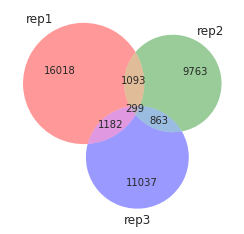

In [21]:
FDR_threshold = 0.2

venn3([set(my_rip_1.loc[my_rip_1['FDR']<FDR_threshold, 'circ_id']),
       set(my_rip_2.loc[my_rip_2['FDR']<FDR_threshold, 'circ_id']),
       set(my_rip_3.loc[my_rip_3['FDR']<FDR_threshold, 'circ_id'])
           
          ],set_labels = ['rep1', 'rep2', 'rep3'])

plt.savefig(figdir/'7_IGF2BP2_RIP_venn.pdf')

In [22]:
three_reps = set(my_rip_1.loc[my_rip_1['FDR']<FDR_threshold, 'circ_id']).intersection(
       set(my_rip_2.loc[my_rip_2['FDR']<FDR_threshold, 'circ_id'])).intersection(
       set(my_rip_3.loc[my_rip_3['FDR']<FDR_threshold, 'circ_id']))

## Compare with published results

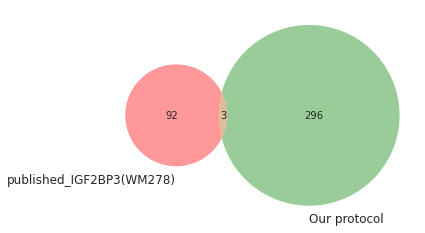

In [23]:
venn2([set(published['circ_id']),
           three_reps
          ],set_labels = ['published_IGF2BP3(WM278)', 'Our protocol'])
plt.savefig(figdir/'7_IGF2BP2_overlap_published.pdf')

In [24]:
circ_bed_df = mega_anno.reset_index()[ 
           ['seqname', 'start', 'end', 'circ_id', 'circ_type', 'strand']
          ]
circ_bed_df['start'] = circ_bed_df['start'].astype(int)
circ_bed_df['end'] = circ_bed_df['end'].astype(int)
circ_bed = BedTool.from_dataframe(circ_bed_df)
eclip = pd.read_csv('/tscc/projects/ps-yeolab5/rbp-portal/encode3/eclip/Skipper/bb63a25/encode_v1/output/reproducible_enriched_windows/IGF2BP3_HepG2_ENCSR993OLA.reproducible_enriched_windows.tsv.gz',
                    sep = '\t')
eclip_bed = BedTool.from_dataframe(eclip[['chr', 'start', 'end', 'name', 'score', 'strand']])

mega_anno['is_eclip'] = mega_anno.index.isin(circ_bed.intersect(eclip_bed, s = True, F=0.5).to_dataframe()['name'])
mega_anno['is_RIP_rep1'] = mega_anno.index.isin(
    my_rip_1.loc[my_rip_1['FDR']<FDR_threshold, 'circ_id'])
mega_anno['is_RIP_rep2'] = mega_anno.index.isin(
    my_rip_2.loc[my_rip_2['FDR']<FDR_threshold, 'circ_id'])
mega_anno['is_RIP_rep3'] = mega_anno.index.isin(
    my_rip_3.loc[my_rip_3['FDR']<FDR_threshold, 'circ_id'])
mega_anno['RIP_reproducible']=(mega_anno['is_RIP_rep1'])&(mega_anno['is_RIP_rep2'])&(mega_anno['is_RIP_rep3'])
mega_anno['is_published']=mega_anno.index.isin(published['circ_id'].tolist())

***** WARNING: File /tmp/pybedtools.qdvtr12x.tmp has inconsistent naming convention for record:
GL000195.1	48955	50396	GL000195.1:48955|50396	Unknown	-

***** WARNING: File /tmp/pybedtools.qdvtr12x.tmp has inconsistent naming convention for record:
GL000195.1	48955	50396	GL000195.1:48955|50396	Unknown	-



In [25]:
only_in_other_protocol = set(published['circ_id'])-set(mega_anno.index)

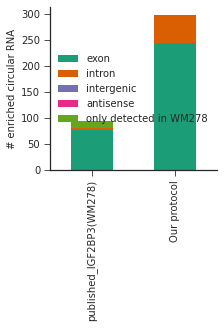

In [26]:
counts_compare = pd.concat([mega_anno.loc[mega_anno['is_published'], 'circ_type'].value_counts(),
           mega_anno.loc[mega_anno['RIP_reproducible'], 'circ_type'].value_counts()],
         axis = 1)
counts_compare.loc['only detected in WM278']=[len(only_in_other_protocol), 0]
counts_compare.columns = ['published_IGF2BP3(WM278)', 'Our protocol']
counts_compare.T.plot.bar(stacked = True, figsize = (3,3))
plt.ylabel('# enriched circular RNA')
sns.despine()
plt.savefig(figdir/'7_IGF2BP2_circtype.pdf')

In [27]:
counts_compare

,published_IGF2BP3(WM278),Our protocol
exon,78.0,245
intron,3.0,51
intergenic,NaN,2
antisense,NaN,1
only detected in WM278,14.0,0


In [28]:
counts_compare.sum()

published_IGF2BP3(WM278)     95.0
Our protocol                299.0
dtype: float64

# compare to the transcirc database

In [29]:
transcirc = pd.read_csv('../notebook/transcirc_metadata.tsv', sep = '\t')
transcirc['circ_id']=transcirc['chrom']+':'+transcirc['start'].astype(str)+'|'+transcirc['end'].astype(str)
transcirc.drop_duplicates(subset = ['circ_id'], inplace = True)

In [30]:
mega_anno['m6A'] = mega_anno.index.map(transcirc.set_index('circ_id')['m6A'].map({1:True, 0:False}))

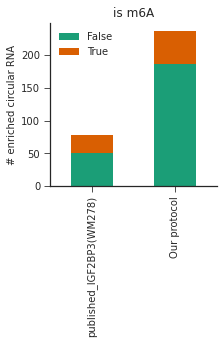

In [31]:
counts_compare = pd.concat([mega_anno.loc[mega_anno['is_published'], 'm6A'].value_counts(),
           mega_anno.loc[mega_anno['RIP_reproducible'], 'm6A'].value_counts()],
         axis = 1)
counts_compare.columns = ['published_IGF2BP3(WM278)', 'Our protocol']
counts_compare.T.plot.bar(stacked = True, figsize = (3,3))
plt.ylabel('# enriched circular RNA')
plt.title('is m6A')
sns.despine()
plt.savefig(figdir/'7_IGF2BP2_m6A.pdf')

In [32]:
from scipy.stats import fisher_exact,chisquare
def testing(df):
    ''' perform fisher exact or chisq given contingency table'''
    if df.shape != (2,2):
        # some outcomes are unobserved
        print(df.shape)
        print('no binding is observed in')
        return 1, np.nan
    if df.le(5).any().any():
        odds_ratio, pvalue = fisher_exact(df)
    else:
        chi, pvalue = chisquare(df.loc[True], (df.loc[True].sum())*df.loc[False].div(df.loc[False].sum()))
        odds_ratio = (df.loc[True, True]/df.loc[True, False])/(df.loc[False, True]/df.loc[False, False])
    return pvalue, odds_ratio

In [33]:
transcirc['m6A'] = (transcirc['m6A']>0)
transcirc['is_IGF2BP3']=transcirc['circ_id'].isin(three_reps)
testing(transcirc.groupby(by = ['is_IGF2BP3', 'm6A']).count()['circ_id'].unstack())

(1.6481809939293494e-05, 1.9602633309635413)

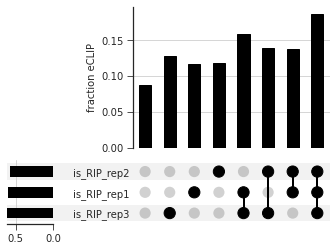

In [34]:
from upsetplot import plot
plot(mega_anno.groupby(by = [c for c in mega_anno.columns if c.startswith('is_RIP_')])['is_eclip'].mean(),
    )
plt.ylabel('fraction eCLIP')
plt.savefig(figdir/'7_IGF2BP2_fraction_eclip.pdf')

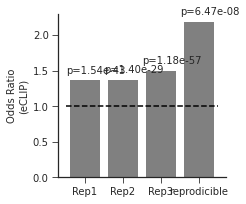

In [35]:
pv_repro, odds_repro = testing(mega_anno.reset_index().groupby(by = ['RIP_reproducible', 'is_eclip']).count()['circ_id'].unstack())
pv1, odds1 = testing(mega_anno.reset_index().groupby(by = ['is_RIP_rep1', 'is_eclip']).count()['circ_id'].unstack())
pv2, odds2 = testing(mega_anno.reset_index().groupby(by = ['is_RIP_rep2', 'is_eclip']).count()['circ_id'].unstack())
pv3, odds3 = testing(mega_anno.reset_index().groupby(by = ['is_RIP_rep3', 'is_eclip']).count()['circ_id'].unstack())

f, ax = plt.subplots(1,1, figsize = (3,3))
x = [0,1,2,3]
y = [odds1, odds2, odds3, odds_repro]
ax.bar(x = x, height = y, color = 'grey')
for xi, yi, pvalue in zip(x,y,[pv1, pv2,pv3, pv_repro]):
    plt.text(xi-0.5, yi+0.1, f'p={pvalue:.2e}')

plt.ylabel('Odds Ratio\n(eCLIP)')

plt.xticks(x, ['Rep1', 'Rep2', 'Rep3', 'reprodicible'])
plt.hlines(y = 1, xmin = -0.5, xmax = max(x)+0.5, linestyle = '--', color = 'black')
sns.despine()
plt.savefig(figdir/'7_IGF2BP2_eclipodds.pdf')

In [36]:
odds1, odds2, odds3, odds_repro

(1.361754549884104, 1.3657614793765336, 1.4992075312576065, 2.1841028230012043)

In [37]:
# # get_circle_fa
# from Bio import SeqIO
# allfa = {}
# for fa in list(Path(indir2).glob('circ/*.fa')):
    

#     for record in SeqIO.parse(fa, "fasta"):
#         allfa[record.id]=record
# len(allfa)


In [38]:
# # fetch bound sequence
# bound_seqrecord = [allfa[i] for i in mega_anno.loc[mega_anno['RIP_reproducible'], 'circ_id'].tolist()]
# bound_seqrecord_r1 = [allfa[i] for i in mega_anno.loc[mega_anno['is_RIP_rep1'], 'circ_id'].tolist()]
# bound_seqrecord_r2 = [allfa[i] for i in mega_anno.loc[mega_anno['is_RIP_rep2'], 'circ_id'].tolist()]
# bound_seqrecord_r3 = [allfa[i] for i in mega_anno.loc[mega_anno['is_RIP_rep3'], 'circ_id'].tolist()]
# notbound_seqrecord = [allfa[i] for i in mega_anno.loc[~mega_anno[['is_RIP_rep3','is_RIP_rep2','is_RIP_rep1']].any(axis = 1), 'circ_id'].tolist()]

In [39]:
# len(bound_seqrecord)

In [40]:
# len(notbound_seqrecord)

In [41]:
# with open(Path(indir)/'IGF2BP3_bound.fa', "w") as output_handle:
#     SeqIO.write(bound_seqrecord, output_handle, "fasta")

# with open(Path(indir)/'IGF2BP3_notbound.fa', "w") as output_handle:
#     SeqIO.write(notbound_seqrecord, output_handle, "fasta")


In [42]:
# indir

module load homer
homer2 denovo -i /home/hsher/scratch/circ_nextera_iter2/output/IGF2BP3_bound.fa\
            -b /home/hsher/scratch/circ_nextera_iter2/output/IGF2BP3_notbound.fa \
            -strand + -o /home/hsher/scratch/RIP_homer

In [43]:
# indir2

#combine and remove redundancy
awk '/^>/{p=seen[$0]++}!p' /home/hsher/scratch/circ_nextera_iter10/output/circ/*index.fa > /home/hsher/scratch/circ_nextera_iter10/output/circ/all.fa